In [23]:
# Загружаем необходимые библиотеки

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.read_csv?

In [35]:
# Загружаем данные для обучения

df = pd.read_csv('data/train.csv')

In [20]:
df.head?

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [22]:
df.drop?

In [36]:
# Бьем на признаки и целевую переменную

X, y = df.drop('Survived', axis=1), df['Survived']

In [23]:
X.describe?

In [37]:
X.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,"Lefebre, Miss. Ida",male,NaN,NaN,NaN,CA. 2343,NaN,B96 B98,S
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


В данных есть пропуски. Это можно видеть по строкам unique, top, freq. (Или это не так, лучше мне не доверять 🤖?) 

<details>
    <summary>Спойлер</summary>
    <p><a href=https://pandas.pydata.org/pandas-docs/stable/missing_data.html>Как работать с пропусками</a></p>
</details>

_Это дело в том, что мы не можем померить np.nan, потому в частоты залязят nan-ы_

In [24]:
X.Embarked.fillna?

In [38]:
# Один из вариантов справиться с пропусками в данных

# Категориальные переменные можно просто заполнить unk-ами
X.Embarked.fillna('unk', inplace=True)
X.Sex.fillna('unk', inplace=True)
X.Pclass.fillna('unk', inplace=True)

# Для числовых занчений, предположим что это бедные люди и они едут в 3ем классе.
# Это необоснованное предположение, в нем можно усомниться и попробовать доказать, что это не так
X.Age.fillna(X.Age.mean(), inplace=True)
X.Fare.fillna(X.Fare[X.Pclass == 3].mean(), inplace=True)
X.SibSp.fillna(X.SibSp[X.Pclass == 3].mean(), inplace=True)
X.Parch.fillna(X.Parch[X.Pclass == 3].mean(), inplace=True)

In [39]:
# Выбросим значения, которые сложные в обработке
X_no_pid = X.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [25]:
pd.DataFrame.apply?

In [40]:
# Переведем пол в 1 -- женский, 0 -- мужской
X_bin_sex = X_no_pid.copy()
X_bin_sex['Sex'] = (X_no_pid.Sex == 'female').apply(lambda x: int(x))

In [41]:
X_bin_sex.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,22.0,1,0,7.2500,S
1,1,1,38.0,1,0,71.2833,C
2,3,1,26.0,0,0,7.9250,S
3,1,1,35.0,1,0,53.1000,S
4,3,0,35.0,0,0,8.0500,S


Применим one hot encoding к Embarked

In [19]:
pd.get_dummies?

In [42]:
X_bin_embk = X_bin_sex.copy()
X_embk_dumm = pd.get_dummies(X_bin_sex['Embarked'], prefix='embk')
X_bin_embk[X_embk_dumm.columns] = X_embk_dumm
X_bin_embk.drop('Embarked', axis=1, inplace=True)

По факту, OHE берет уникальные значения Embarked (S, C, Q, unk) и создает из них новую матрицу из нулей и единиц. 

Таблица ниже иллюстрирует эту идею

In [18]:
pd.concat((X_bin_sex.Embarked, X_embk_dumm), axis=1).head(10)

,Embarked,embk_C,embk_Q,embk_S,embk_unk
0,S,0,0,1,0
1,C,1,0,0,0
2,S,0,0,1,0
3,S,0,0,1,0
4,S,0,0,1,0
5,Q,0,1,0,0
6,S,0,0,1,0
7,S,0,0,1,0
8,S,0,0,1,0
9,C,1,0,0,0


In [12]:
X_bin_embk.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,embk_C,embk_Q,embk_S,embk_unk
0,3,0,22.0,1,0,7.2500,0,0,1,0
1,1,1,38.0,1,0,71.2833,1,0,0,0
2,3,1,26.0,0,0,7.9250,0,0,1,0
3,1,1,35.0,1,0,53.1000,0,0,1,0
4,3,0,35.0,0,0,8.0500,0,0,1,0


Также применим OHE к пассажирскому классу

In [43]:
X_bin_cls = X_bin_embk.copy()
X_bin_cls['Pclass'] = X_bin_cls['Pclass'].apply(lambda x: str(x))
X_cls_dumm = pd.get_dummies(X_bin_cls['Pclass'], prefix='p_cls')
X_bin_cls[X_cls_dumm.columns] = X_cls_dumm
X_bin_cls.drop('Pclass', axis=1, inplace=True)

In [14]:
X_bin_cls.head()

,Sex,Age,SibSp,Parch,Fare,embk_C,embk_Q,embk_S,embk_unk,p_cls_1,p_cls_2,p_cls_3
0,0,22.0,1,0,7.2500,0,0,1,0,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,0,1,0,0
2,1,26.0,0,0,7.9250,0,0,1,0,0,0,1
3,1,35.0,1,0,53.1000,0,0,1,0,1,0,0
4,0,35.0,0,0,8.0500,0,0,1,0,0,0,1


Перевод [pd.DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.values.html) в [numpy ndarray](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.html)

In [44]:
X_ar = X_bin_cls.values

In [45]:
X_ar

array([[ 0.        , 22.        ,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 1.        , 38.        ,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 1.        , 26.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.        , 29.69911765,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.        , 26.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.        , 32.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

In [46]:
y_ar = y.values

In [18]:
y_ar[:10]

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1])

Самое простое разбиение данных на обучающую и валидационную выборки

Также стоит глянуть на [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html)

In [26]:
train_test_split?

In [47]:
x_train, x_test, y_train, y_test = train_test_split(X_ar, y_ar, test_size=0.25)

In [48]:
X_ar.shape, y_ar.shape

((891, 12), (891,))

In [21]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((668, 12), (223, 12), (668,), (223,))

Обучение логистической регрессии

In [49]:
clf = LogisticRegression()
clf.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Подсчет [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

In [50]:
clf.score(x_test, y_test)

0.7892376681614349

[OPTIONAL] ROC AUC

In [51]:
roc_auc_score(y_test, clf.predict_proba(x_test)[:, 1])

0.8413253413253414

In [52]:
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(x_test)[:, 1])

In [53]:
fpr_random, tpr_random, _ = roc_curve(y_test, [0.5]*y_test.shape[0])

Text(0,0.5,'True Positive Rate')

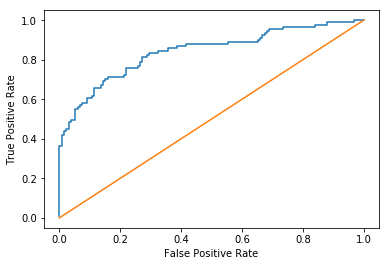

In [54]:
plt.plot(fpr, tpr)
plt.plot(fpr_random, tpr_random)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

"Важность" признаков

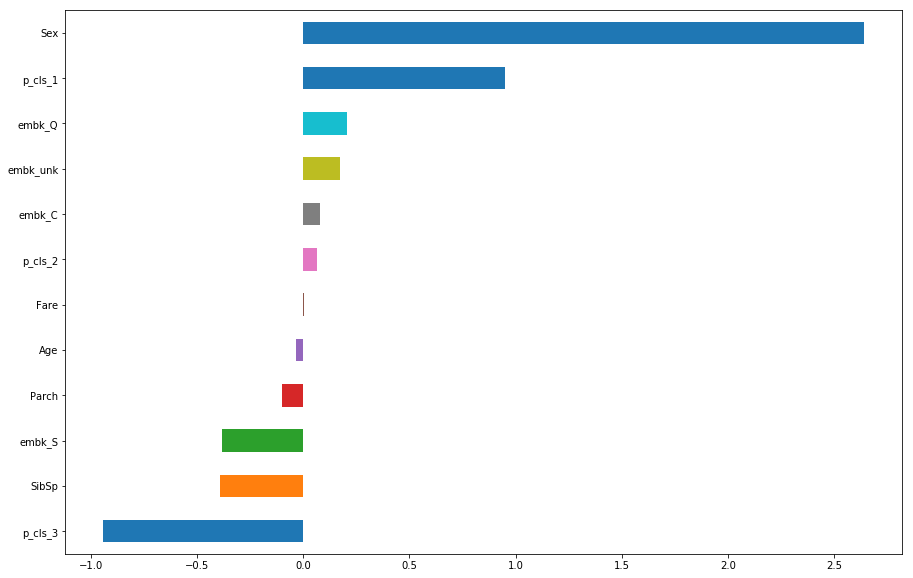

In [55]:
pd.Series(clf.coef_[0], index=X_bin_cls.columns).sort_values().plot(kind='barh', figsize=(15, 10))

А какие шансы выжить есть у тебя?

In [63]:
def to_titanic(sex=1, age=20, sibsp=0, parch=0, fare=16, embk='unk', p_cls=3):
    vec = np.zeros_like(X_bin_cls.columns)
    names = X_bin_cls.columns.tolist()
    sex_idx, age_idx, sib_idx, par_idx, fare_idx, embk_idx, p_cls_idx = map(names.index, ['Sex', 'Age', 'SibSp', 
                                                                                          'Parch', 'Fare', 
                                                                                          f'embk_{embk}', 
                                                                                          f'p_cls_{p_cls}'])
    vec[sex_idx] = sex; vec[age_idx] = age; vec[sib_idx] = sibsp
    vec[par_idx] = parch; vec[fare_idx] = fare_idx; vec[embk_idx] = 1; vec[p_cls_idx] = 1
    return vec.reshape(1, -1)
    

In [66]:
vec = to_titanic()

In [67]:
clf.predict_proba(vec)

array([[0.21828254, 0.78171746]])

In [68]:
print(f"Шансы выжить: {round(clf.predict_proba(check.reshape((1, -1)))[0, 1], 2)}")

NameError: name 'check' is not defined

## Задание

### Первая половина оценки

Сделать такую модель, чтобы точность (accuracy) была выше, чем та, что есть сейчас.

В результате, мы посчитаем половину оценки следующим образом:

$$mark_{inclass} = ((accuracy_{predicted} - accuracy_{baseline}) - (1 - \frac{X.train.shape[0] + X.test.shape[0]}{X.original.shape[0]})) * 45$$

где

1. $X.train.shape$ - размер используемой Вами обучающей выборки 
2. $X.test.shape$ - размер используемой Вами тестовой выборки
3. $X.original.shape$ - размер сходной таблицы ($891 \times 12 $)
4. $accuracy_{baseline}$ - точность приведенная в примере
5. $accuracy_{predicted}$ - точность посчитанная Вашей моделью (Или вами, можете руками считать)

### Вторая половина оценки

Прогнать свое решение на тестовых данных и загрузить свое решение на [kaggle]. Тогда вторая половина оценки будет посчитана следующим образом:

$$mark_{inclass} = (\frac{accuracy_{kaggle}}{5}) * 45$$

### В итоге

После того, как работа будет выполнена, то надо будет оформить свою работу и либо показать ее в классе либо послать по почте. __Работы будут ожидаться до 23:50 следующей субботы без пенальти, после первой субботы будет пенальти mark * 0.5, а после 23:50 второй субботы работа будет оценена на 0 баллов__

Мы понимаем, что датасет очень заезженный и тут сложно сделать что-то оригинальное, но мы просим прявить смекалочку и попробовать набрать как можно больше баллов самим.

Хорошо оформленные работы с пояснениями будут оценены дополнительными бонусами 🤑



### Рекомендации
- Посмотреть на те признаки, что мы убрали, возможно среди них есть что-то полезное
    - Мб что-то с именами сделать?
- Подумать над тем, как мы заполняем пропуски
- Помедидитовать над важностью классов (?)
- Попробовать другие модели
- Поиграть с параметрами модели (рекомендуется кроссвалидация)
- Посмотреть в kernel-ы соревнования